In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.finance as mpf
from matplotlib.pylab import date2num
from HuobiServices import *
from DataUtils import *
import talib
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import os
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
lmap=lambda func,it: list(map(lambda x:func(x),it))
lfilter=lambda func,it: list(filter(lambda x:func(x),it))
z_score=lambda x:(x-np.mean(x,axis=0))/(np.std(x,axis=0)+1e-5)

In [51]:
class DRL_Crypto_portfolio(object):
    def __init__(self, feature_number, action_size=1,c=1e-5, hidden_units_number=[128, 64], learning_rate=0.001):
        tf.reset_default_graph()
        self.s = tf.placeholder(dtype=tf.float32, shape=[None, feature_number], name='s')
        self.d = tf.placeholder(dtype=tf.float32, shape=[None,action_size-1], name='d')
        self.s_buffer=[]
        self.d_buffer=[]
        self.c=c
        self.action_size=action_size
        self.dropout_keep_prob = tf.placeholder(dtype=tf.float32, shape=[], name='dropout_keep_prob')
        with tf.variable_scope('rnn_encoder', initializer=tf.contrib.layers.xavier_initializer(uniform=True), regularizer=tf.contrib.layers.l2_regularizer(0.01)):
#             cell=self._add_GRU(units_number=128,keep_prob=self.dropout_keep_prob)
            cells=self._add_GRUs(units_number=[128,action_size],activation=[tf.nn.relu,tf.nn.relu])
            self.rnn_input=tf.expand_dims(self.s,axis=0)
            self.rnn_output,_=tf.nn.dynamic_rnn(inputs=self.rnn_input,cell=cells,dtype=tf.float32)
#             self.rnn_output=tf.contrib.layers.layer_norm(self.rnn_output)
            self.a_prob=tf.unstack(self.rnn_output,axis=0)[0]
            
#         with tf.variable_scope('supervised',initializer=tf.contrib.layers.xavier_initializer(uniform=True), regularizer=tf.contrib.layers.l2_regularizer(0.01)):
#             self.state_predict = self._add_dense_layer(inputs=self.rnn_output, output_shape=hidden_units_number, drop_keep_prob=self.dropout_keep_prob, act=tf.nn.relu, use_bias=True)
#             self.state_predict = self._add_dense_layer(inputs=self.rnn_output, output_shape=[feature_number], drop_keep_prob=self.dropout_keep_prob, act=None, use_bias=True)
#             self.state_loss=tf.losses.mean_squared_error(self.state_predict,self.s_next)
            
        with tf.variable_scope('direct_RL',initializer=tf.contrib.layers.xavier_initializer(uniform=True), regularizer=tf.contrib.layers.l2_regularizer(0.01)):
#             self.rnn_output=tf.stop_gradient(self.rnn_output)
#             self.a_prob = self._add_dense_layer(inputs=self.rnn_output, output_shape=hidden_units_number+[action_size], drop_keep_prob=self.dropout_keep_prob, act=tf.nn.relu, use_bias=True)
#             self.a_prob = self._add_dense_layer(inputs=self.a_prob, output_shape=, drop_keep_prob=self.dropout_keep_prob, act=None, use_bias=True)
            self.a_out = tf.nn.softmax(self.a_prob,axis=-1)
            self.a_out = tf.concat((tf.zeros(dtype=tf.float32,shape=[1,self.action_size]), self.a_out), axis=0)
            self.reward = tf.reduce_sum(self.d * self.a_out[:-1,:-1] - self.c * tf.abs(self.a_out[1:,:-1] - self.a_out[:-1,:-1]),axis=1)
            self.total_reward = tf.reduce_sum(self.reward)
            self.mean_reward = tf.reduce_mean(self.reward)
            
        with tf.variable_scope('train'):
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = optimizer.minimize(-self.mean_reward)
        self.init_op = tf.global_variables_initializer()
        self.session = tf.Session()
        self.saver = tf.train.Saver()
        
    def init_model(self):
        self.session.run(self.init_op)
    
    def _add_dense_layer(self, inputs, output_shape, drop_keep_prob, act=tf.nn.relu, use_bias=True):
        output = inputs
        for n in output_shape:
            output = tf.layers.dense(output, n, activation=act, use_bias=use_bias)
            output = tf.nn.dropout(output, drop_keep_prob)
        return output
    
    def _add_GRU(self,units_number,activation=tf.nn.relu,keep_prob=1.0):
        cell = tf.contrib.rnn.LSTMCell(units_number,activation=activation)
        cell = tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
        return cell
    
    def _add_GRUs(self,units_number,activation,keep_prob=1.0):
        cells=tf.contrib.rnn.MultiRNNCell(cells=[ self._add_GRU(units_number=n,activation=a) for n,a in zip(units_number,activation)])
        return cells
    
    def _add_gru_cell(self, units_number, activation=tf.nn.relu):
        return tf.contrib.rnn.GRUCell(num_units=units_number, activation=activation)
    
    def train(self, drop=0.85):
#         np.random.shuffle(random_index)
        feed = {
            self.s: np.array(self.s_buffer),
            self.d: np.array(self.d_buffer),
            self.dropout_keep_prob: drop
        }
        self.session.run([self.train_op], feed_dict=feed)
    
    def restore_buffer(self):
        self.s_buffer = []
        self.d_buffer = []
    def save_current_state(self,s,d):
        self.s_buffer.append(s)
        self.d_buffer.append(d)
    
    def trade(self,train=False, drop=1.0, prob=False):
        feed = {
            self.s: np.array(self.s_buffer),
            self.dropout_keep_prob: drop
        }
        a_prob = self.session.run([self.a_out], feed_dict=feed)
        a_prob = a_prob[-1][-1].flatten()
        return a_prob
    def load_model(self, model_path='./DRLModel'):
        self.saver.restore(self.session, model_path + '/model')

    def save_model(self, model_path='./DRLModel'):
        if not os.path.exists(model_path):
            os.mkdir(model_path)
        model_file = model_path + '/model'
        self.saver.save(self.session, model_file)

In [5]:
assets=assets=['bat']

In [6]:
asset_data=lfilter(lambda x:x[1] is not None,lmap(lambda x:(x,kline(x,interval='30min',count=2000)),assets))
asset_data=lmap(lambda x:(x[0],generate_tech_data(x[1],close_name='close',high_name='high',low_name='low',open_name='open')),asset_data)
asset_data=dict(asset_data)
asset_data=pd.Panel(asset_data)

In [60]:
model=DRL_Crypto_portfolio(action_size=asset_data.shape[0]+1,feature_number=asset_data.shape[2]*asset_data.shape[0],learning_rate=1e-3)
model.init_model()
model.restore_buffer()

In [61]:
normalize_length=20
train_length=1500
batch_size=64
c=1e-5
epoch=30
train_r=[]
train_mean_r=[]
test_r=[]
test_mean_r=[]
for e in range(epoch):
    train_reward=[]
    train_actions=[]
    test_reward=[]
    test_actions=[]
    previous_action=np.zeros(asset_data.shape[0]+1)
    for t in range(normalize_length,train_length):
        state=asset_data[:,t-normalize_length:t,:]
        diff=state[:,:,'diff'].iloc[-1]
        state=state.values
        state=state.reshape((state.shape[1],state.shape[0]*state.shape[2]))
        state=z_score(state)[None,-1]
        model.save_current_state(s=state[0],d=diff.values)
        action=model.trade(state)
        r=np.sum(asset_data[:,:,'diff'].iloc[t].values*action[:-1]-c*np.sum(np.abs(previous_action-action)))
        previous_action=action
        train_reward.append(r)
        train_actions.append(action)
        if t % batch_size == 0:
            model.train(drop=0.8)
            model.restore_buffer()
    print(e,'train_reward',np.sum(train_reward),np.mean(train_reward))
    train_r.append(np.sum(train_reward))
    train_mean_r.append(np.mean(train_reward))
    previous_action=np.zeros(asset_data.shape[0]+1)
    for t in range(train_length,asset_data.shape[1]):
        state=asset_data[:,t-normalize_length:t,:]
        diff=state[:,:,'diff'].iloc[-1]
        state=state.values
        state=state.reshape((state.shape[1],state.shape[0]*state.shape[2]))
        state=z_score(state)[None,-1]
        model.save_current_state(s=state[0],d=diff.values)
        action=model.trade(state)
        r=np.sum(asset_data[:,:,'diff'].iloc[t].values*action[:-1]-c*np.sum(np.abs(previous_action-action)))
        test_reward.append(r)
        test_actions.append(action)
        previous_action=action
        if t % batch_size==0:
            model.restore_buffer()
    print(e,'test_reward',np.sum(test_reward),np.mean(test_reward))
    test_r.append(np.sum(test_reward))
    test_mean_r.append(np.mean(test_reward))
    model.restore_buffer()
    if np.sum(np.sum(test_reward))>0.3: break
model.restore_buffer()

0 train_reward -0.20988026 -0.00014085924
0 test_reward 0.11156319 0.00025529333
1 train_reward -0.1193928 -8.012939e-05
1 test_reward 0.06607037 0.00015119078
2 train_reward -0.11566612 -7.762827e-05
2 test_reward 0.10894904 0.0002493113
3 train_reward -0.05081929 -3.4106906e-05
3 test_reward 0.10464406 0.00023946009
4 train_reward 0.016102433 1.0807003e-05
4 test_reward 0.11122994 0.00025453075
5 train_reward 0.15590574 0.000104634724
5 test_reward 0.13650985 0.00031237953
6 train_reward 0.26429778 0.00017738107
6 test_reward -0.006009415 -1.3751522e-05
7 train_reward 0.29222578 0.00019612469
7 test_reward 0.080391824 0.00018396298
8 train_reward 0.16453628 0.000110427034
8 test_reward 0.14932051 0.00034169454
9 train_reward 0.27945355 0.00018755271
9 test_reward 0.13078636 0.00029928228
10 train_reward 0.2589702 0.0001738055
10 test_reward 0.12590584 0.00028811407
11 train_reward 0.24600175 0.00016510184
11 test_reward 0.097795956 0.00022378938
12 train_reward 0.20099095 0.000134893

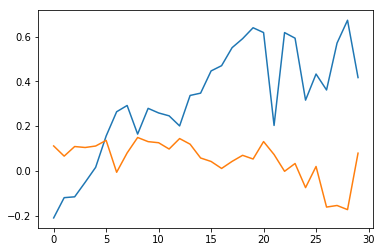

In [62]:
plt.plot(train_r)
plt.plot(test_r)

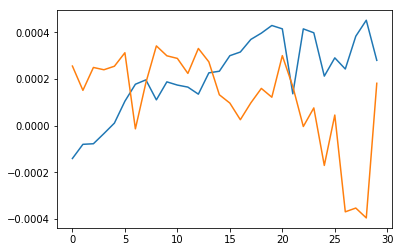

In [63]:
plt.plot(train_mean_r)
plt.plot(test_mean_r)

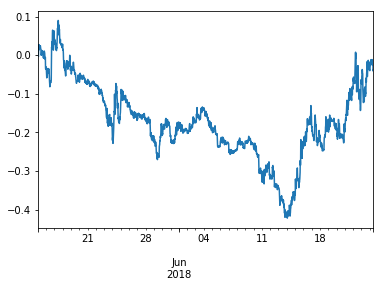

In [64]:
asset_data[:,:,'diff'].sum(axis=1).cumsum().plot()

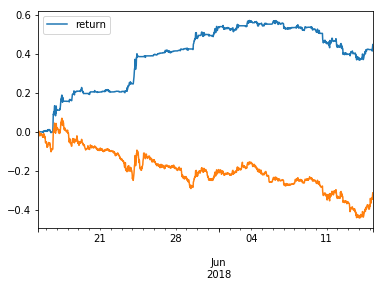

In [65]:
pd.DataFrame(train_reward,index=asset_data[:,normalize_length:train_length,'diff'].index,columns=['return']).cumsum().plot()
asset_data[:,normalize_length:train_length,'diff'].sum(axis=1).cumsum().plot()

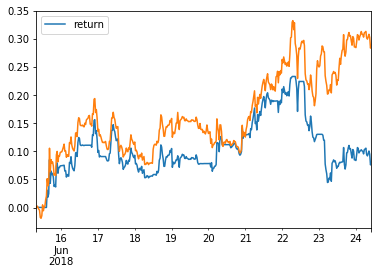

In [66]:
pd.DataFrame(test_reward,index=asset_data[:,train_length:,'diff'].index,columns=['return']).cumsum().plot()
asset_data[:,train_length:,'diff'].sum(axis=1).cumsum().plot()

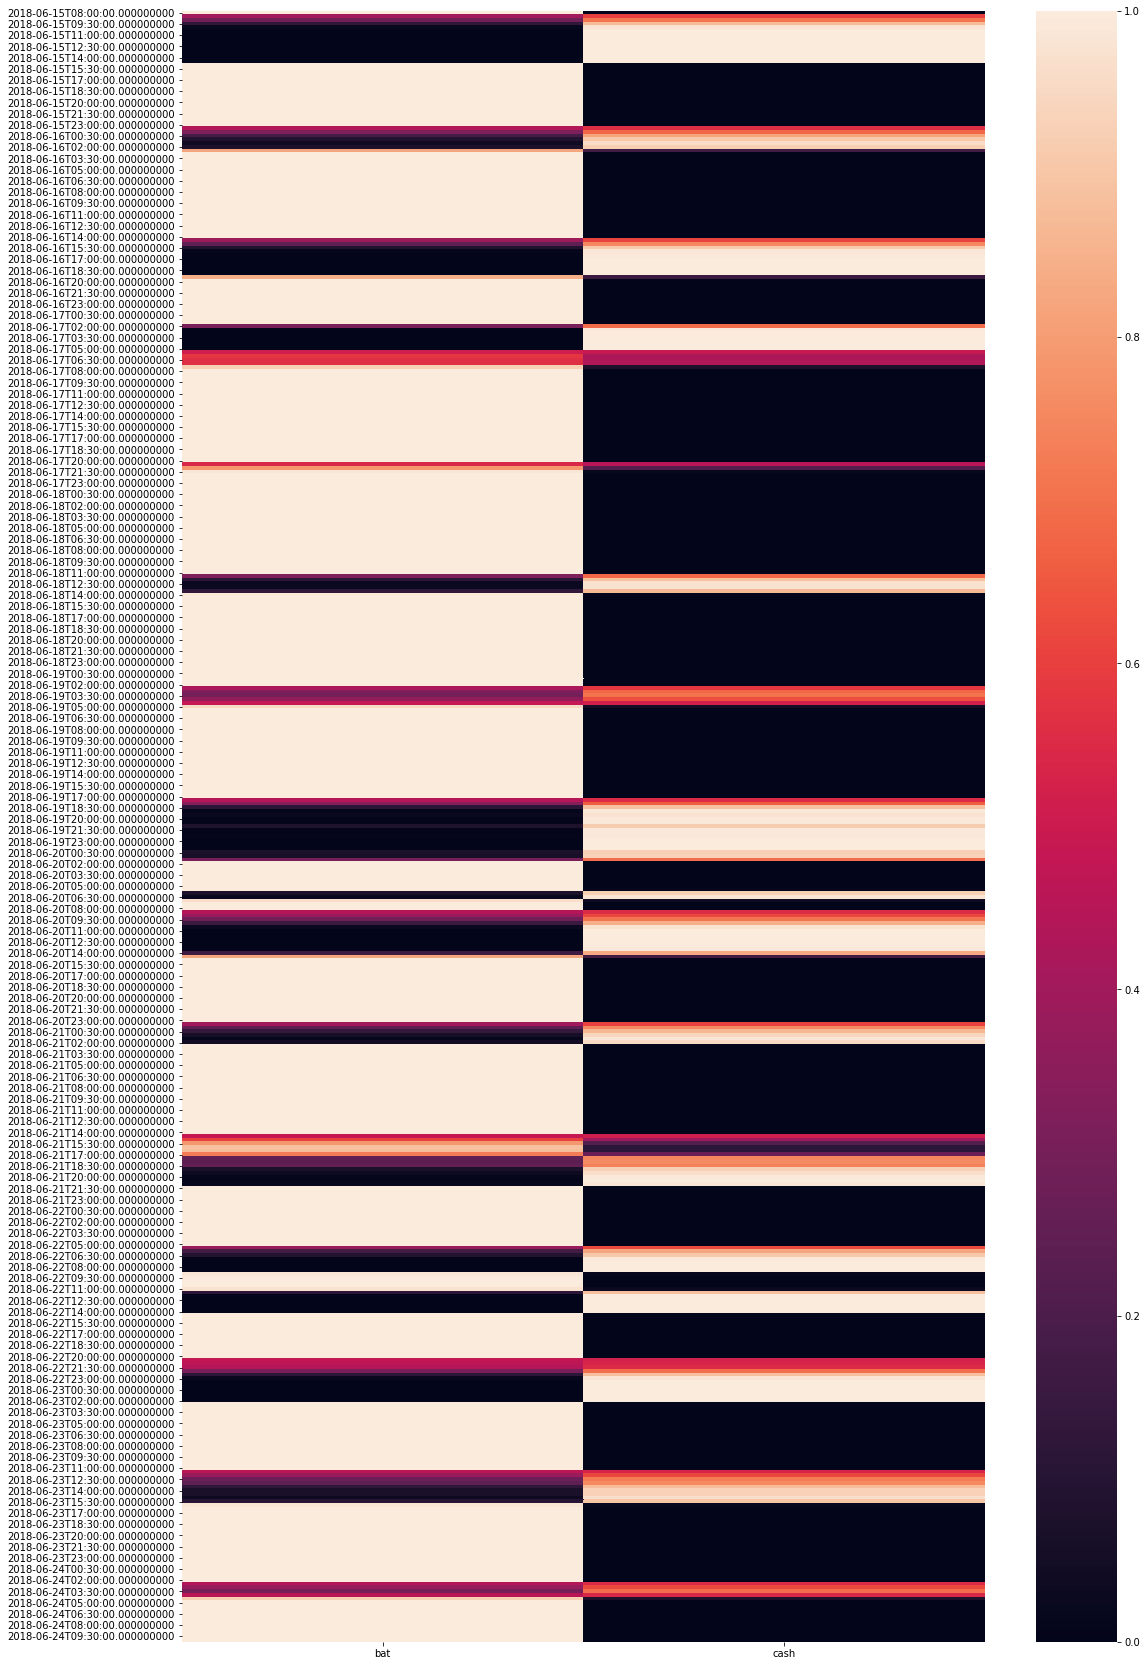

In [67]:
test_action_df=pd.DataFrame(test_actions,index=asset_data[:,train_length:,'diff'].index,columns=list(asset_data.items)+['cash'])
plt.figure(figsize=(18,30))
sns.heatmap(test_action_df)